# Data Import

In [97]:
import sqlite3
import pandas as pd
con = sqlite3.connect("../unified-final.db")
cur = con.cursor()

df = pd.read_sql_query("SELECT * FROM prod_desc", con)
df['AB'] = df['AB'].apply(lambda x: int.from_bytes(x, "little"))
df =  df.drop(columns=['level_0','index'])
df.shape

(11521, 218)

# Feature  Selection

seperate target variable

In [98]:
y = df['AB']
df = df.drop(columns='AB')
df.shape



(11521, 217)

Drop non numeric columns

In [99]:
df = df.select_dtypes(include=[float, int])
df.shape

(11521, 210)

Drop features with 0 variance

In [100]:
df = df.loc[:, df.var() > 0]
df.shape

c:\Users\Etienne\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: overflow encountered in square
  sqr = _ensure_numeric((avg - values) ** 2)


(11521, 141)

Drop correlated features. (This would otherwise make problems with regularisation and convergence of regression)

In [101]:
# copy paste from https://stackoverflow.com/questions/29294983/how-to-calculate-correlation-between-all-columns-and-remove-highly-correlated-on
import numpy as np

# Create correlation matrix
corr_matrix = df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]

# Drop features 
df.drop(to_drop, axis=1, inplace=True)
df.shape

(11521, 31)

Drop rows containing nan

In [102]:
df = df.dropna(axis = 0)
df.shape

(11521, 31)

# Fit and cross validation

In [103]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(df,y)

c:\Users\Etienne\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

This did not work. To get the regression to convergence, the features are scaled.

In [104]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaled_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
scaled_df = scaled_df.dropna(axis=1)
scaled_df.shape

c:\Users\Etienne\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\extmath.py:1159: RuntimeWarning: overflow encountered in square
  temp **= 2
c:\Users\Etienne\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\extmath.py:1165: RuntimeWarning: overflow encountered in square
  new_unnormalized_variance -= correction**2 / new_sample_count
c:\Users\Etienne\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\extmath.py:1165: RuntimeWarning: invalid value encountered in subtract
  new_unnormalized_variance -= correction**2 / new_sample_count
c:\Users\Etienne\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_data.py:84: RuntimeWarning: overflow encountered in square
  upper_bound = n_samples * eps * var + (n_samples * mean * eps) ** 2


(11521, 30)

Retry fit

In [105]:
model.fit(scaled_df,y)


LogisticRegression()

Now that we have achieved convergence we can properly crossvalidate this model.

In [113]:
# Chat gpt
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import classification_report, accuracy_score


X = scaled_df


# Define the LogisticRegressionCV model
log_reg_cv = LogisticRegressionCV(cv=100, random_state=42, max_iter=1000)

# Perform cross-validation and get predictions
y_pred = cross_val_predict(log_reg_cv, X, y, cv=100)

# Generate classification report
report = classification_report(y, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Display the classification report
print("Classification Report:")
print(report_df)

# Get cross-validation scores (accuracy)
cv_scores = cross_val_score(log_reg_cv, X, y, cv=100, scoring='accuracy')

# Display cross-validation scores
print("\nCross-validation Accuracy Scores:", cv_scores)
print("Mean CV Accuracy:", np.mean(cv_scores))
print("Standard Deviation of CV Accuracy:", np.std(cv_scores))

# Generate a detailed cross-validation report
cv_report = {
    "Fold": list(range(1, 101)),
    "Accuracy": cv_scores
}

cv_report_df = pd.DataFrame(cv_report)
cv_report_df.loc["Mean"] = ["Mean", np.mean(cv_scores)]
cv_report_df.loc["Std"] = ["Std", np.std(cv_scores)]

print("\nDetailed Cross-Validation Report:")
print(cv_report_df)


Classification Report:
              precision    recall  f1-score       support
0              0.661565  0.648623  0.655030   5265.000000
1              0.709074  0.720748  0.714863   6256.000000
accuracy       0.687788  0.687788  0.687788      0.687788
macro avg      0.685320  0.684686  0.684947  11521.000000
weighted avg   0.687363  0.687788  0.687520  11521.000000

Cross-validation Accuracy Scores: [0.75       0.76724138 0.65517241 0.68965517 0.75       0.71551724
 0.68965517 0.67241379 0.76724138 0.68103448 0.62068966 0.62931034
 0.68965517 0.63793103 0.72413793 0.68965517 0.75       0.75
 0.65517241 0.63793103 0.73275862 0.69565217 0.71304348 0.66086957
 0.72173913 0.80869565 0.79130435 0.65217391 0.63478261 0.71304348
 0.62608696 0.68695652 0.71304348 0.72173913 0.73913043 0.74782609
 0.73043478 0.66956522 0.60869565 0.69565217 0.68695652 0.71304348
 0.68695652 0.63478261 0.60869565 0.69565217 0.73913043 0.73043478
 0.73043478 0.6173913  0.72173913 0.69565217 0.67826087 0.660869

Classification Report:
              precision    recall  f1-score       support
0              0.661565  0.648623  0.655030   5265.000000
1              0.709074  0.720748  0.714863   6256.000000
accuracy       0.687788  0.687788  0.687788      0.687788
macro avg      0.685320  0.684686  0.684947  11521.000000
weighted avg   0.687363  0.687788  0.687520  11521.000000

Cross-validation Accuracy Scores: [0.75       0.76724138 0.65517241 0.68965517 0.75       0.71551724
 0.68965517 0.67241379 0.76724138 0.68103448 0.62068966 0.62931034
 0.68965517 0.63793103 0.72413793 0.68965517 0.75       0.75
 0.65517241 0.63793103 0.73275862 0.69565217 0.71304348 0.66086957
 0.72173913 0.80869565 0.79130435 0.65217391 0.63478261 0.71304348
 0.62608696 0.68695652 0.71304348 0.72173913 0.73913043 0.74782609
 0.73043478 0.66956522 0.60869565 0.69565217 0.68695652 0.71304348
 0.68695652 0.63478261 0.60869565 0.69565217 0.73913043 0.73043478
 0.73043478 0.6173913  0.72173913 0.69565217 0.67826087 0.66086957
 0.69565217 0.62608696 0.69565217 0.72173913 0.66086957 0.67826087
 0.7826087  0.69565217 0.6173913  0.72173913 0.60869565 0.64347826
 0.74782609 0.74782609 0.65217391 0.72173913 0.68695652 0.62608696
 0.5826087  0.69565217 0.66956522 0.70434783 0.73913043 0.66086957
 0.67826087 0.64347826 0.59130435 0.63478261 0.66086957 0.64347826
 0.65217391 0.74782609 0.64347826 0.66956522 0.5826087  0.67826087
 0.72173913 0.62608696 0.74782609 0.67826087 0.70434783 0.70434783
 0.70434783 0.65217391 0.66086957 0.7826087 ]
Mean CV Accuracy: 0.687769115442279
Standard Deviation of CV Accuracy: 0.04867733243960572

Detailed Cross-Validation Report:
      Fold  Accuracy
0        1  0.750000
1        2  0.767241
2        3  0.655172
3        4  0.689655
4        5  0.750000
...    ...       ...
97      98  0.652174
98      99  0.660870
99     100  0.782609
Mean  Mean  0.687769
Std    Std  0.048677

[102 rows x 2 columns]

# Regularisation
Maybe we can even improve our accuracy with regularisation

In [107]:
# Chat gpt
from sklearn.model_selection import train_test_split, cross_val_score
def calculateAccuracy(elasticNetRation):
    # Initialize and train the LogisticRegressionCV model
    model_cv = LogisticRegressionCV(cv=5, random_state=42, penalty = 'elasticnet', solver= 'saga', l1_ratios=[elasticNetRation])
    model_cv.fit(scaled_df, y)

    # Perform cross-validation to get accuracy scores
    cv_scores = cross_val_score(model_cv, scaled_df, y, cv=5, scoring='accuracy')

    # Calculate mean and standard deviation of accuracies
    mean_accuracy = np.mean(cv_scores)
    std_accuracy = np.std(cv_scores)
    return [mean_accuracy, std_accuracy]


res = calculateAccuracy(0.5)
elasticnetration = []
means = []
std = []

for i in range(0,10):
    res = calculateAccuracy(i/10)
    elasticnetration.append(i/10)
    means.append(res[0])
    std.append(res[1])

print(elasticnetration)
print(means)
print(std)


KeyboardInterrupt: 

# Plot results

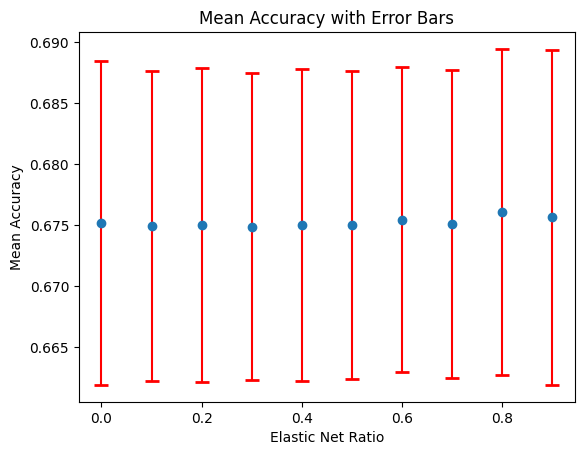

In [ ]:
# Chat gpt
import matplotlib.pyplot as plt

# Data points
x = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
y = [0.6752021194866232, 0.6749417028199567, 0.6750285083755122, 0.6748548972644011, 0.6750285083755122, 0.6750285083755122, 0.6754625361532899, 0.6751153139310677, 0.6760701750421788, 0.6756361472644011]
z = [0.013263987627501793, 0.012711652770777996, 0.012868759302430604, 0.012554981002835653, 0.012730413185772838, 0.012596530390016528, 0.012493432734491442, 0.012620836551625119, 0.013349898406444167, 0.01369078097757757]

# Create scatter plot with error bars
plt.errorbar(x, y, yerr=z, fmt='o', ecolor='red', capsize=5, capthick=2)
plt.xlabel('Elastic Net Ratio')
plt.ylabel('Mean Accuracy')
plt.title('Mean Accuracy with Error Bars')
plt.show()


# Conclusion
Regularisation did not improve mean accuracy